# Importing

In [1]:
import sys
sys.executable

'/home/sarah/Documentos/PSGCode/psg-venv/bin/python'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
from geexhp import datasetup as dset

import tensorflow as tf
from geexhp import cnn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import corner
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow.keras.utils import plot_model # type: ignore
import visualkeras
from geexhp import datavis
datavis.configure_matplotlib()


# Data Setup

In [4]:
#folder = "../parallel/data/"
#df = dset.combine_parquet(folder=folder, keyword="_", output_file=True)

In [5]:
df = pd.read_parquet("../data/__data.parquet")

In [6]:
dfabun = dset.extract_abundances(df)
dfabun.dropna(inplace=True)

# Preprocessing data and creating the training and testing datasets

In [7]:
# Define inputs and outputs
inputs = 'ALBEDO'
outputs_list = ['OBJECT-DIAMETER', 'OBJECT-GRAVITY', 'ATMOSPHERE-PRESSURE', 'ATMOSPHERE-TEMPERATURE',
                'C2H6', 'CH4', 'CO', 'CO2', 'H2', 'H2O', 'HCN', 'N2',
                'N2O', 'NH3', 'O2', 'O3', 'PH3']

# 2. Split the Data
# Prepare inputs
X = np.stack(dfabun[inputs].values)
# Prepare outputs
y = dfabun[outputs_list].copy()

# Extract stratification labels
stratify_labels = dfabun["Earth_type"]

In [8]:
# Initial train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=dfabun["Earth_type"])

# Get the indices of the training data
train_indices = y_train.index

# Get stratify labels for training data
stratify_train_labels = dfabun.loc[train_indices, "Earth_type"]

# Perform train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=stratify_train_labels)

In [9]:
# 3. Normalize the Data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

num_features = len(outputs_list)
y_scalers = []
y_train_scaled = np.zeros_like(y_train)
y_val_scaled = np.zeros_like(y_val)
y_test_scaled = np.zeros_like(y_test)

for i in range(num_features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled[:, i] = scaler.fit_transform(y_train.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_val_scaled[:, i] = scaler.transform(y_val.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_test_scaled[:, i] = scaler.transform(y_test.to_numpy()[:, i].reshape(-1, 1)).ravel()
    y_scalers.append(scaler)

In [10]:
# 6. Reshape inputs for CNN
X_train_scaled = X_train_scaled[..., np.newaxis]
X_val_scaled = X_val_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]

input_shape = X_train_scaled.shape[1:]  # (sequence_length, 1)
output_units = y_train_scaled.shape[1]  # Number of outputs

In [11]:
y_train_dict = {output_name: y_train_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}
y_val_dict = {output_name: y_val_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}
y_test_dict = {output_name: y_test_scaled[:, idx] for idx, output_name in enumerate(outputs_list)}

In [12]:
batch_size = 32

def _parse_function(x, y):
    x = tf.cast(x, tf.float32)
    y = {key: tf.cast(value, tf.float32) for key, value in y.items()}
    return x, y

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_dict))
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_dict))
validation_dataset = validation_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_dict))
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Convolutional Neural Network 1D (CNN) with tuning hyperparameters

In [13]:
# Instantiate the HyperTuningBayCNN class
cnn_tuner = cnn.HyperTuningBayCNN(input_shape, output_units, outputs_list)

In [14]:
# Perform hyperparameter search
best_hps = cnn_tuner.search(train_dataset, validation_dataset, max_trials=30, search_epochs=3)

Trial 11 Complete [00h 25m 43s]
val_loss: 5.8430585861206055

Best val_loss So Far: 4.846534252166748
Total elapsed time: 07h 02m 30s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
1                 |2                 |conv_layers
128               |96                |filters_0
9                 |9                 |kernel_size_0
0.1               |0.2               |dropout_rate_0
2                 |1                 |dense_layers
256               |192               |units_0
0.2               |0.1               |dropout_rate_dense_0
0.00057085        |0.0010378         |learning_rate
96                |16                |filters_1
3                 |3                 |kernel_size_1
0.1               |0.1               |dropout_rate_1
128               |None              |units_1
0.1               |None              |dropout_rate_dense_1
128               |None              |units_2
0.2               |None              |dropout_rate_dense_2
16         

KeyboardInterrupt: 

In [19]:
# Fit the best model
best_model, history = cnn_tuner.fit_best_model(train_dataset, validation_dataset, epochs=100, patience=8)

Epoch 1/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 7497s 9s/step - ATMOSPHERE-PRESSURE_loss: 1.1149 - ATMOSPHERE-TEMPERATURE_loss: 1.1070 - C2H6_loss: 1.4155 - CH4_loss: 0.8263 - CO2_loss: 1.3529 - CO_loss: 1.3814 - H2O_loss: 0.8496 - H2_loss: 2.0006 - HCN_loss: 0.9011 - N2O_loss: 0.6317 - N2_loss: 0.7104 - NH3_loss: 1.1131 - O2_loss: 0.9353 - O3_loss: 1.7676 - OBJECT-DIAMETER_loss: 1.2863 - OBJECT-GRAVITY_loss: 1.2543 - PH3_loss: 0.9199 - loss: 19.5716 - val_ATMOSPHERE-PRESSURE_loss: 0.4355 - val_ATMOSPHERE-TEMPERATURE_loss: 0.4128 - val_C2H6_loss: 0.9731 - val_CH4_loss: 0.1895 - val_CO2_loss: 0.3560 - val_CO_loss: 0.4881 - val_H2O_loss: 0.3058 - val_H2_loss: 0.6851 - val_HCN_loss: 0.2327 - val_N2O_loss: 0.2937 - val_N2_loss: 0.2191 - val_NH3_loss: 0.4743 - val_O2_loss: 0.3053 - val_O3_loss: 1.8032 - val_OBJECT-DIAMETER_loss: 0.4594 - val_OBJECT-GRAVITY_loss: 0.4413 - val_PH3_loss: 0.4194 - val_loss: 8.5028
Epoch 2/100
795/795 ━━━━━━━━━━━━━━━━━━━━ 369s 464ms/step - ATMOSPHERE-PRESSURE_loss: 0.3

In [20]:
cnn_tuner.save("model.keras")

Model saved at model.keras


In [21]:
cnn_tuner.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2304, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2296, 96)  │        960 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2288, 96)  │     83,040 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1144, 96)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1144, 96)  │        384 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_4        │ (None, 1144, 96)  │          0 │ batch_normalizat… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1142, 16)  │      4,624 │ mc_dropout_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1140, 16)  │        784 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 570, 16)   │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 570, 16)   │         64 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_5        │ (None, 570, 16)   │          0 │ batch_normalizat… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 9120)      │          0 │ mc_dropout_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 192)       │  1,751,232 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_6        │ (None, 192)       │          0 │ dense_3[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ATMOSPHERE-PRESSURE │ (None, 1)         │        193 │ mc_dropout_6[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ATMOSPHERE-TEMPERA… │ (None, 1)         │        193 │ mc_dropout_6[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C2H6 (Dense)        │ (None, 1)         │        193 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CH4 (Dense)         │ (None, 1)         │        193 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CO (Dense)          │ (None, 1)         │        193 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CO2 (Dense)         │ (None, 1)         │        193 │ mc_dropout_6[0][

 Total params: 5,532,660 (21.11 MB)

 Trainable params: 1,844,145 (7.03 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 3,688,291 (14.07 MB)

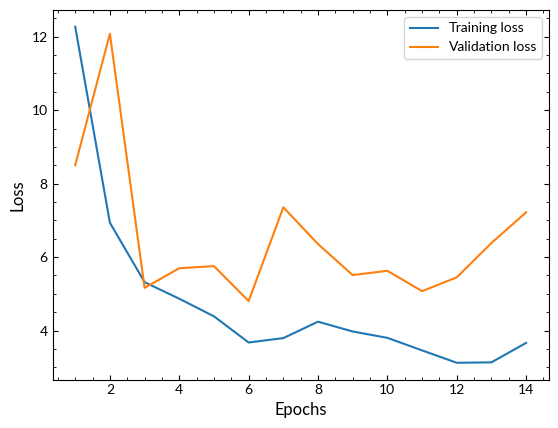

In [22]:
cnn_tuner.plot_losses()

In [14]:
#cnn_tuner.load_model("model.keras")

Model loaded from model.keras


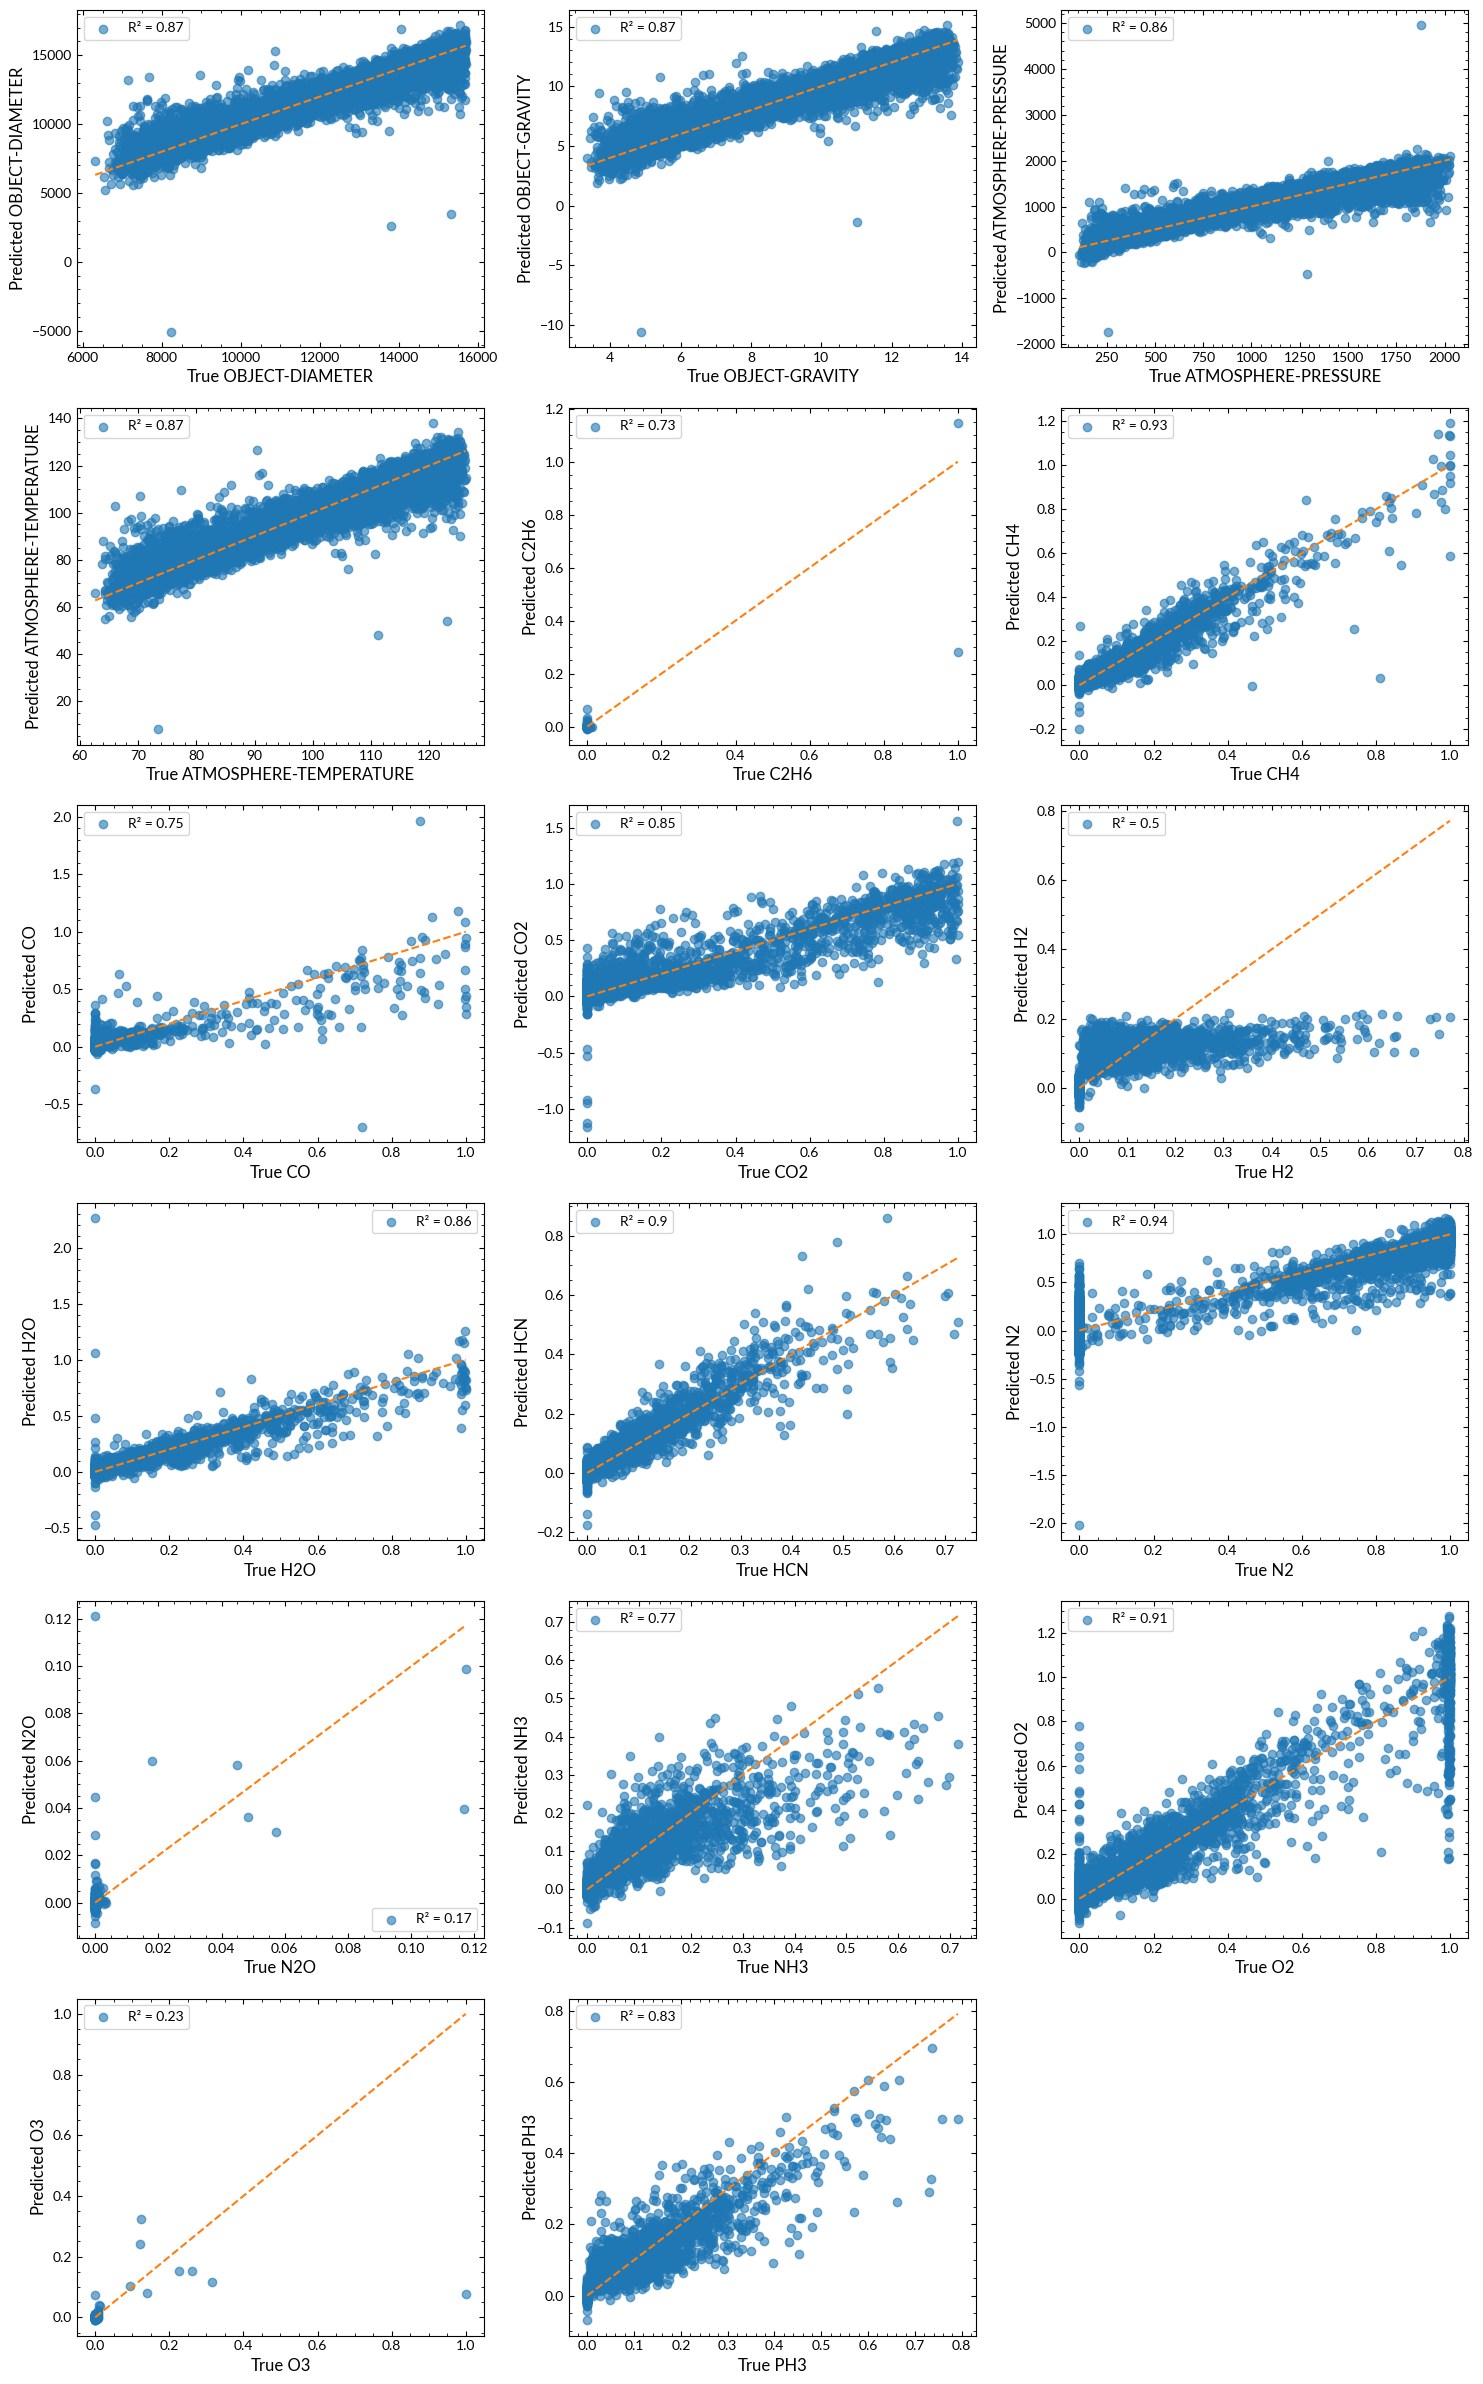

In [23]:
results = cnn_tuner.evaluate(test_dataset, outputs_list, y_scalers, plot=True)

In [24]:
results

,R² scores,MAE scores,RMSE scores
OBJECT-DIAMETER,0.87,602.940002,851.669983
OBJECT-GRAVITY,0.87,0.700000,0.980000
ATMOSPHERE-PRESSURE,0.86,133.279999,190.330002
ATMOSPHERE-TEMPERATURE,0.87,4.180000,5.850000
C2H6,0.73,0.000000,0.010000
CH4,0.93,0.010000,0.030000
CO,0.75,0.010000,0.040000
CO2,0.85,0.050000,0.090000
H2,0.50,0.020000,0.060000
H2O,0.86,0.020000,0.050000


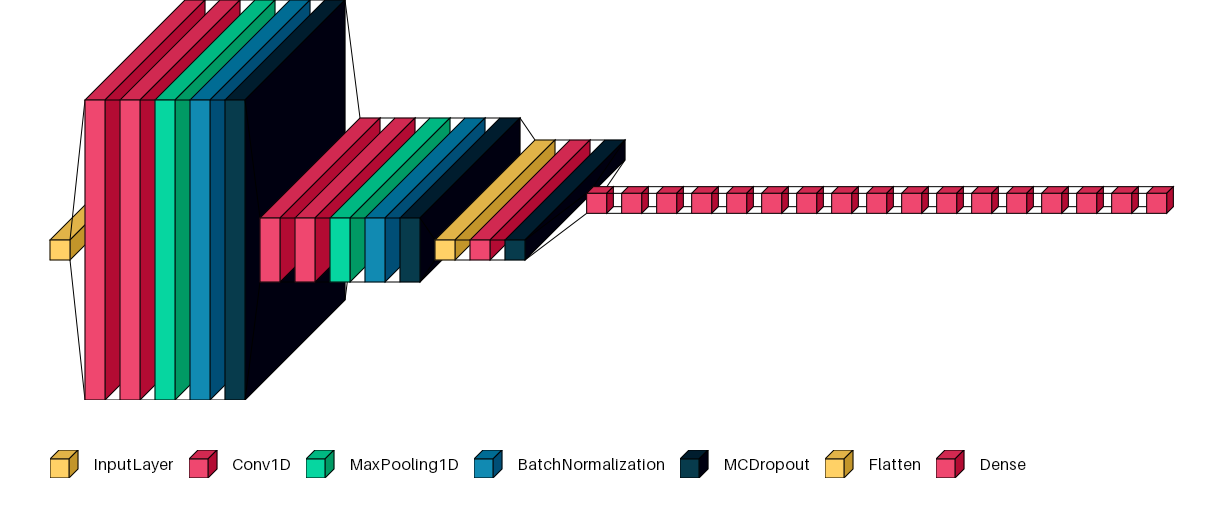

In [25]:
font = ImageFont.load_default(size = 16)

visualkeras.layered_view(cnn_tuner.best_model, to_file='../images/model_architecture.png', legend=True,
                        draw_funnel=True, draw_volume=True,
                        one_dim_orientation="x", max_xy=300, max_z=100, font=font, padding=50, spacing=15, shade_step=30)

In [26]:
#plot_model(cnn_tuner.best_model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,  rankdir='TB', dpi=100)

# Stochastic predictions

In [27]:
num_samples = 1 

# Selecionar indices aleatórios
indices = np.random.choice(X_test_scaled.shape[0], size=num_samples, replace=False)

# Selecionar o subconjunto
X_test_subset = X_test_scaled[indices]
y_test_subset = y_test_scaled[indices]

In [28]:
# Número de iterações para Monte Carlo Dropout
n_iter = 1000

# Obter predições com incerteza para o subconjunto
predictions_dict = cnn_tuner.predict_with_uncertainty(X_test_subset, n_iter=n_iter)

In [29]:
# Inverter as transformações nas predições
predictions_inv_dict = {}

for idx, name in enumerate(cnn_tuner.outputs_list):
    preds = predictions_dict[name]  # shape: (n_iter, num_samples, 1)
    preds = preds.reshape(-1, 1)  # shape: (n_iter * num_samples, 1)

    # Inverter a normalização com o scaler correto
    preds_inv = y_scalers[idx].inverse_transform(preds)
    predictions_inv_dict[name] = preds_inv.flatten()

# Combinar predições
predictions_combined = np.column_stack([predictions_inv_dict[name] for name in cnn_tuner.outputs_list])

# Preparar os valores verdadeiros (para NumPy array)
y_test_dict = {name: y_test_subset[:, idx].reshape(-1, 1) for idx, name in enumerate(cnn_tuner.outputs_list)}
y_test_inv_dict = {}

for idx, name in enumerate(cnn_tuner.outputs_list):
    y_true_inv = y_scalers[idx].inverse_transform(y_test_dict[name])
    y_test_inv_dict[name] = y_true_inv.flatten()

# Repetir os valores verdadeiros para corresponder às predições
y_test_combined = np.column_stack([np.repeat(y_test_inv_dict[name], n_iter) for name in cnn_tuner.outputs_list])

# Calcular erros se desejar
errors_combined = predictions_combined - y_test_combined

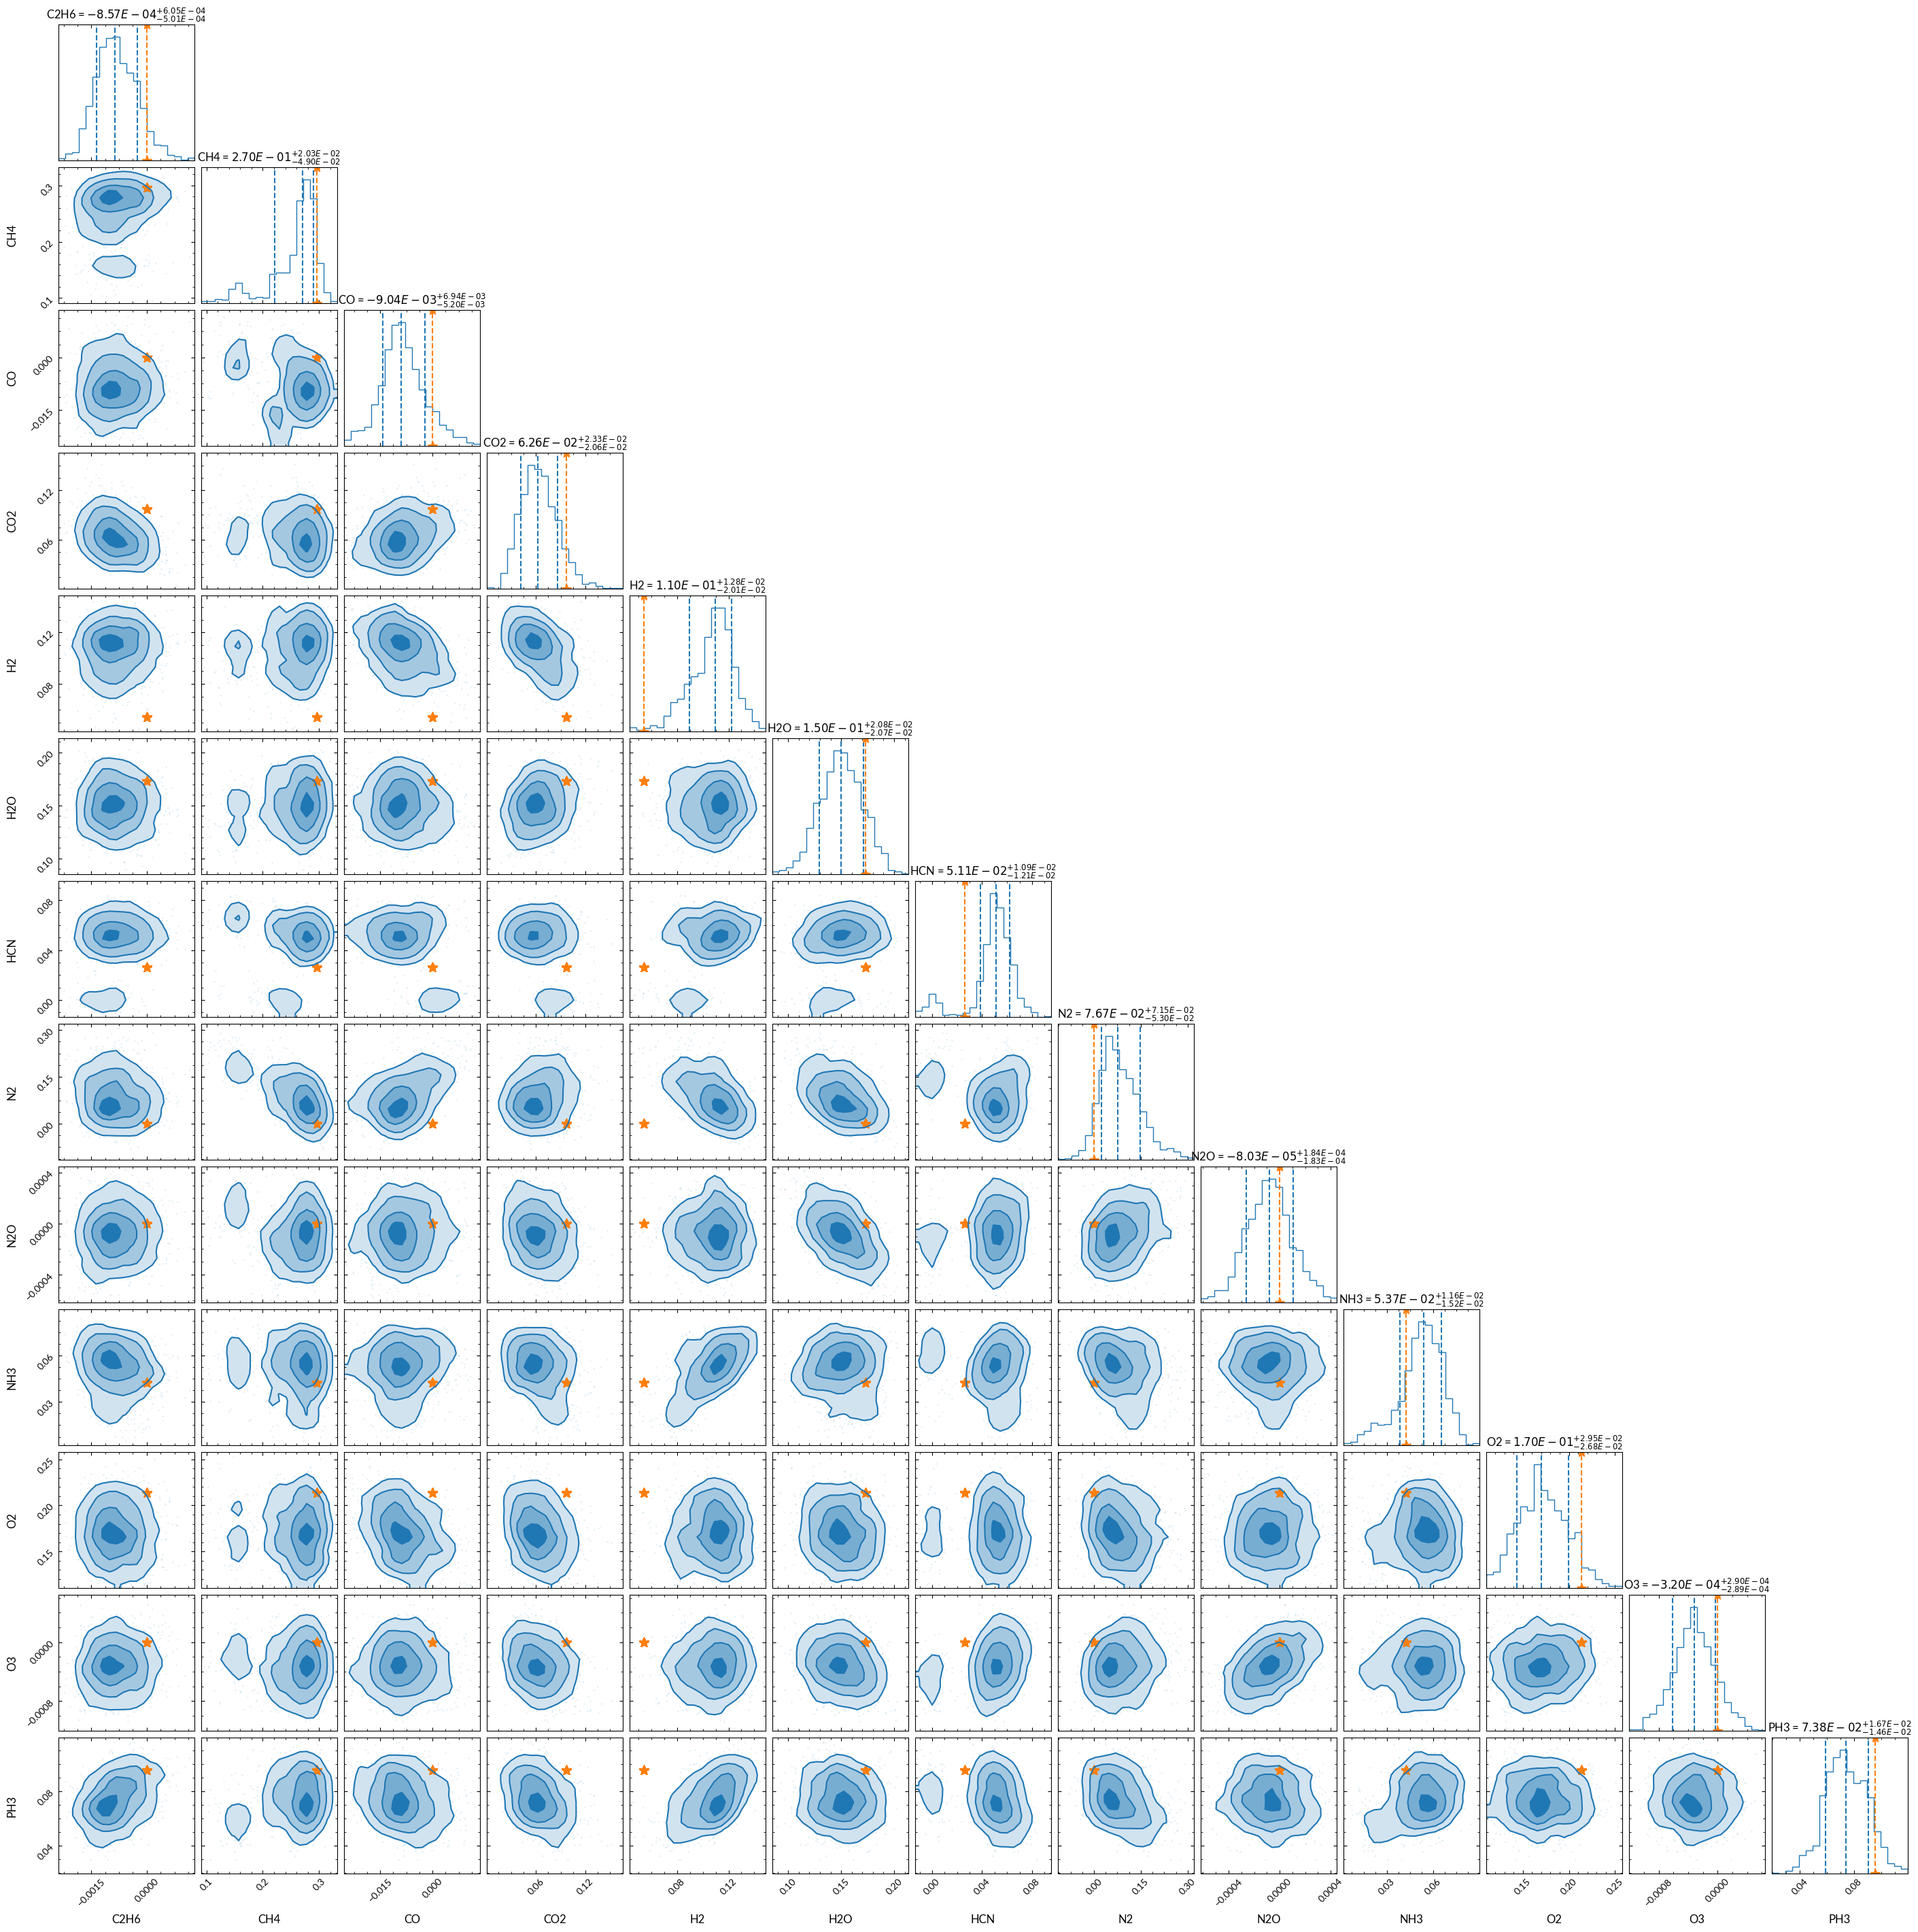

In [31]:
# Dados a serem plotados
data_to_plot = predictions_combined  # Ou 'errors_combined' se preferir plotar os erros

#abundances = ['C2H6', 'CH4', 'CO', 'CO2', 'H2', 'H2O', 'HCN', 'N2', 'N2O', 'NH3', 'O2', 'O3', 'PH3']
abundances = ["H2O", "O3", "CH4", "O2", "CO2"]
abundance_indices = [cnn_tuner.outputs_list.index(name) for name in abundances]

# Selecionar parâmetros a serem plotados (opcional)
# param_indices = list(range(17)) 
data_to_plot = data_to_plot[:, abundance_indices]
feature_names_selected = [cnn_tuner.outputs_list[i] for i in abundance_indices]

# Plotting the corner plot with only the abundances in blue color
figure = corner.corner(
    data_to_plot,
    labels=feature_names_selected,
    show_titles=True,
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    title_fmt=".2E",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 12},
    max_n_ticks=3,
    smooth=0.9,
    color='tab:blue'
)

# True values (to be plotted as star points)
true_values_to_plot = y_test_combined[:, abundance_indices]

# Add the true values as stars to the corner plot
axes = np.array(figure.axes).reshape((len(abundance_indices), len(abundance_indices)))

# Loop over the diagonal and off-diagonal subplots to add true values
for i in range(len(abundance_indices)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:  # Diagonal plot (histogram)
            ax.axvline(true_values_to_plot[0, i], color='tab:orange', linestyle='--', marker='*', markersize=10)
        else:  # Off-diagonal plot (scatter)
            ax.scatter(true_values_to_plot[:, j], true_values_to_plot[:, i], color='tab:orange', marker='*', s=100)

plt.savefig('corner_plot_predictions.png')
plt.show()